In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Divide the annotation file into multiple .txt files for each image
# Define the paths
annotation_path = "./grocery_annotations/annotation.txt"
image_dir = "./Images_Grocery/ShelfImages/"

# Open the annotation file
with open(annotation_path, 'r') as f:
    lines = f.readlines()

# Process each line
for line in lines:
    parts = line.split()
    image_name = parts[0]
    num_objects = int(parts[1])
    objects = [parts[i:i+5] for i in range(2, len(parts), 5)]

    # Create a new annotation file for this image
    with open(os.path.join(image_dir, image_name + '.txt'), 'w') as f:
        for obj in objects:
            # Write the object annotation to the file
            f.write(' '.join(obj) + '\n')

In [3]:
from sklearn.model_selection import train_test_split

def list_files(full_data_path = "./Images_Grocery/ShelfImages/", image_ext = '.JPG', test_size = 0.15, validation_size = 0.15):

    files = []

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(image_ext):
                files.append(file)

    # Split the data into training and testing
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    # Split the training data into training and validation
    train_files, val_files = train_test_split(train_files, test_size=validation_size, random_state=42)

    return train_files, val_files, test_files

In [4]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

255 training files
45 validation files
54 test files


In [5]:
input_size = 244
new_size = (244, 244)  # New size (height, width)

def resize_image_and_box(img, box):
    # Calculate the scale factors
    y_scale = input_size / img.shape[0]
    x_scale = input_size / img.shape[1]

    # Resize the image
    resized_img = cv2.resize(img, new_size)

    x, y, w, h = box[0], box[1], box[2], box[3]
    
    # Scale the bounding box coordinates
    resized_box = [int(box[0] * x_scale), int(box[1] * y_scale), int(box[2] * x_scale), int(box[3] * y_scale)]

    return resized_img, resized_box

def format_image(img1, box1):
    img = img1.copy()
    box = box1.copy()
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_AREA)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    return new_image, new_box

In [6]:
class CustomDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.dataset = self.create_dataset(images_folder)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        entry = self.dataset[idx]

        # If you want to apply any image transformations
        if self.transform:
            entry["image"] = self.transform(entry["image"])

        # Convert to PyTorch tensor
        image = transforms.ToTensor()(entry["image"])
        # Convert bounding boxes and class labels to tensors
        bounding_boxes = torch.tensor(entry["bounding_boxes"], dtype=float)
        class_labels = torch.tensor(entry["class_label"], dtype=torch.int64)
        bounding_boxes = bounding_boxes / torch.tensor([image.shape[2], image.shape[1], image.shape[2], image.shape[1]])
        # Create target dictionary
        target = {
            'boxes': bounding_boxes,
            'labels': class_labels
        }
        return image, target
    
    def create_dataset(self, files, full_data_path = "./Images_Grocery/ShelfImages/"):
        dataset = []
        
        for file in files:
            # Load the image in grayscale
            img = cv2.imread(os.path.join(full_data_path, file), cv2.IMREAD_GRAYSCALE)
            k = 1
            labels = []
            with open(os.path.join(full_data_path, file + ".txt"), 'r') as fp:
                lines = fp.readlines()
                boxes = []
                for line in lines:
                    parts = line.split()
                    box = np.array(parts[:4], dtype=int)
                    xmin = box[0]
                    ymin = box[1]
                    xmax = box[0] + box[2]
                    ymax = box[1] + box[3]
                    box[0] = xmin
                    box[1] = ymin
                    box[2] = xmax
                    box[3] = ymax
                    if(box[0] == 0):
                        box[0] = 0.1
                    copy_img, box = format_image(img, box)
                    boxes.append(box)
                    labels.append(k)
                    
                dataset.append({
                    "image": copy_img,
                    "bounding_boxes": boxes,
                    "class_label": labels
                })

        return dataset


custom_dataset = CustomDataset(training_files)
validation_dataset = CustomDataset(validation_files)

# Example: Using DataLoader
dataloader = DataLoader(custom_dataset, batch_size=1, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True, num_workers=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


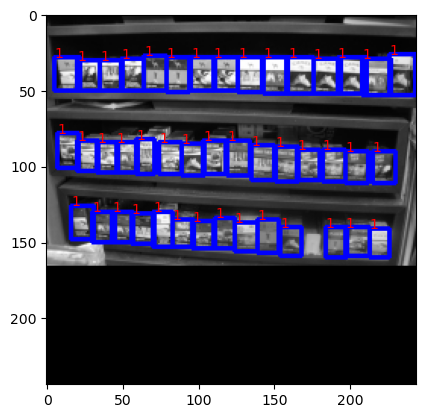

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get the first batch from the dataloader
first_batch = next(iter(dataloader))

# Get the first image, bounding boxes, and labels from the batch
images = first_batch[0]
targets = first_batch[1]

# Convert the image tensor to a numpy array and transpose the dimensions for matplotlib
image = images[0].squeeze(0).squeeze(0)
# Convert the image to float32
image = image.numpy().astype(np.float32)

temp_color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image_height, image_width, _ = temp_color_img.shape

boxes = targets['boxes'][0].numpy()
labels = targets['labels'][0].numpy()

for box, label in zip(boxes, labels):
    norm_xmin, norm_ymin, norm_xmax, norm_ymax = box[0], box[1], box[2], box[3]
    xmin = int(norm_xmin * image_width)
    ymin = int(norm_ymin * image_height)
    xmax = int(norm_xmax * image_width)
    ymax = int(norm_ymax * image_height)

    cv2.rectangle(temp_color_img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
    plt.text(xmin, ymin, str(label), color='red')
plt.imshow(temp_color_img)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.detection import ssd300_vgg16  # Choose an SSD model from torchvision

# Create SSD model
ssd_model = ssd300_vgg16(pretrained=True)  # You can use a different SSD model


# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssd_model = ssd_model.to(device)

# Optimizer
optimizer = optim.SGD(ssd_model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        inputs = inputs.to(device)

        ls = []
        # Move each tensor in the 'targets' dictionary to the device
        targets = {key: value.squeeze(0).to(device) for key, value in targets.items()}
        ls.append(targets)

        optimizer.zero_grad()

        output = ssd_model(inputs, [targets])

        # The output is a dictionary containing the losses
        loss_dict = output

        # Calculate the total loss
        total_loss = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

c:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


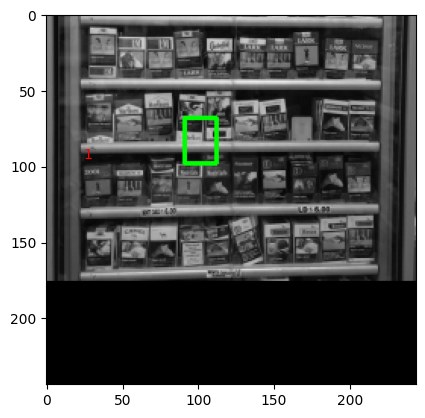

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


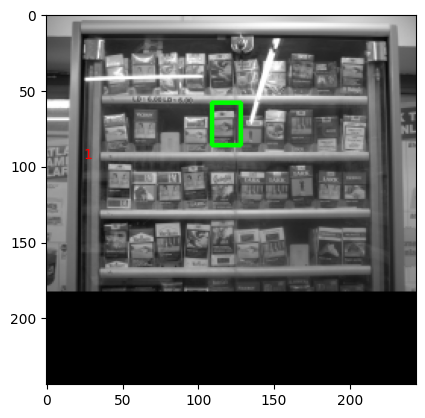

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


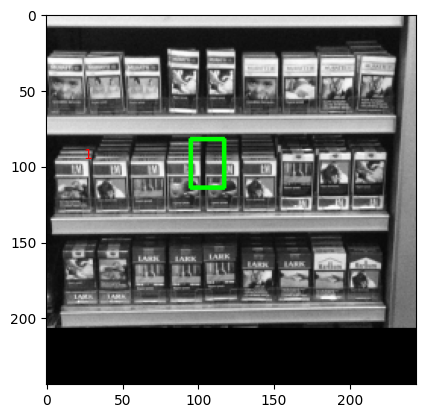

In [ ]:
# Put the model in evaluation mode
ssd_model.eval()

# Loop over the test dataset
for idx, (images, targets) in enumerate(validation_dataloader):
    # Move the images and targets to the device
    images = list(image.to(device) for image in images)
    targets = [{k: v.squeeze(0).to(device) for k, v in targets.items()}]

    # Make predictions
    with torch.no_grad():
        predictions = ssd_model(images)

    # Draw the predicted boxes
    for i, image in enumerate(images):
        # Convert the image tensor to a numpy array and transpose the dimensions for matplotlib
        image_copy = image.squeeze(0)
        image_copy = image_copy.cpu().numpy().astype(np.float32)
        temp_color_img = cv2.cvtColor(image_copy, cv2.COLOR_GRAY2RGB)

        # Get the predicted boxes and labels
        pred_boxes = predictions[i]['boxes'].cpu().numpy()
        pred_labels = predictions[i]['labels'].cpu().numpy()
        target_boxes = targets[i]['boxes'].cpu().numpy()
        target_labels = targets[i]['labels'].cpu().numpy()
        
        # Draw the predicted boxes
        for pred_box, pred_label in zip(pred_boxes, pred_labels):
            pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box[0], pred_box[1], pred_box[2], pred_box[3]
            pred_xmin = int(pred_xmin * image_width)
            pred_ymin = int(pred_ymin * image_height)
            pred_xmax = int(pred_xmax * image_width)
            pred_ymax = int(pred_ymax * image_height)
            cv2.rectangle(temp_color_img, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (0, 255, 0), 2)
            plt.text(pred_xmin, pred_ymin, str(pred_label), color='red')  # Fixed label variable

        # Show the image with predicted boxes
        plt.imshow(temp_color_img)
        plt.show()
